In [7]:
from datetime import datetime, timezone, timedelta
import matplotlib.pyplot as plt
import os
import xarray as xr

from ONCToolbox import ONCToolbox, format_datetime

In [8]:
save_dir = 'onc_data'
onct = ONCToolbox(save_dir=save_dir)

In [9]:
date_to = datetime.now(timezone.utc) # End of the data request.
date_from = date_to - timedelta(days = 1) # Start of the data request.

In [10]:
loc_code = 'SEVIP'
dev_cat_code = 'ADCP150KHZ'
ext = 'nc'
dpc = 'RADCPTS'

params = {'locationCode': loc_code,
          'dateFrom': format_datetime(date_from),
          'dateTo': format_datetime(date_to),
          'extension': ext,
          'deviceCategoryCode': dev_cat_code,
          'dataProductCode': dpc}

req = onct.requestDataProduct(filters = params)
status = onct.runDataProduct(req['dpRequestId'])
data_files = []
meta_files = []
for run_id in status['runIds']:
    down = onct.downloadDataProduct(run_id)
    for file_info in down:
        fn = file_info['file']
        fp = os.path.join(save_dir,fn)
        if fn.endswith('.nc'):
            data_files.append(fp)
        elif fn.endswith('.xml'):
            meta_files.append(fp)

Request Id: 27237942
Estimated File Size: 115 MB
Estimated Processing Time: 5 min
To cancel the running data product, run 'onc.cancelDataProduct(27237942)'

   queued
   data product running.................
   2 files generated for this data product
   complete



In [11]:
ds_list = [xr.open_dataset(f) for f in data_files]
adcp = xr.concat(ds_list, dim='time', combine_attrs = 'drop_conflicts', join = 'outer', data_vars = 'all')
adcp = adcp.dropna(dim = 'time', how = 'all')

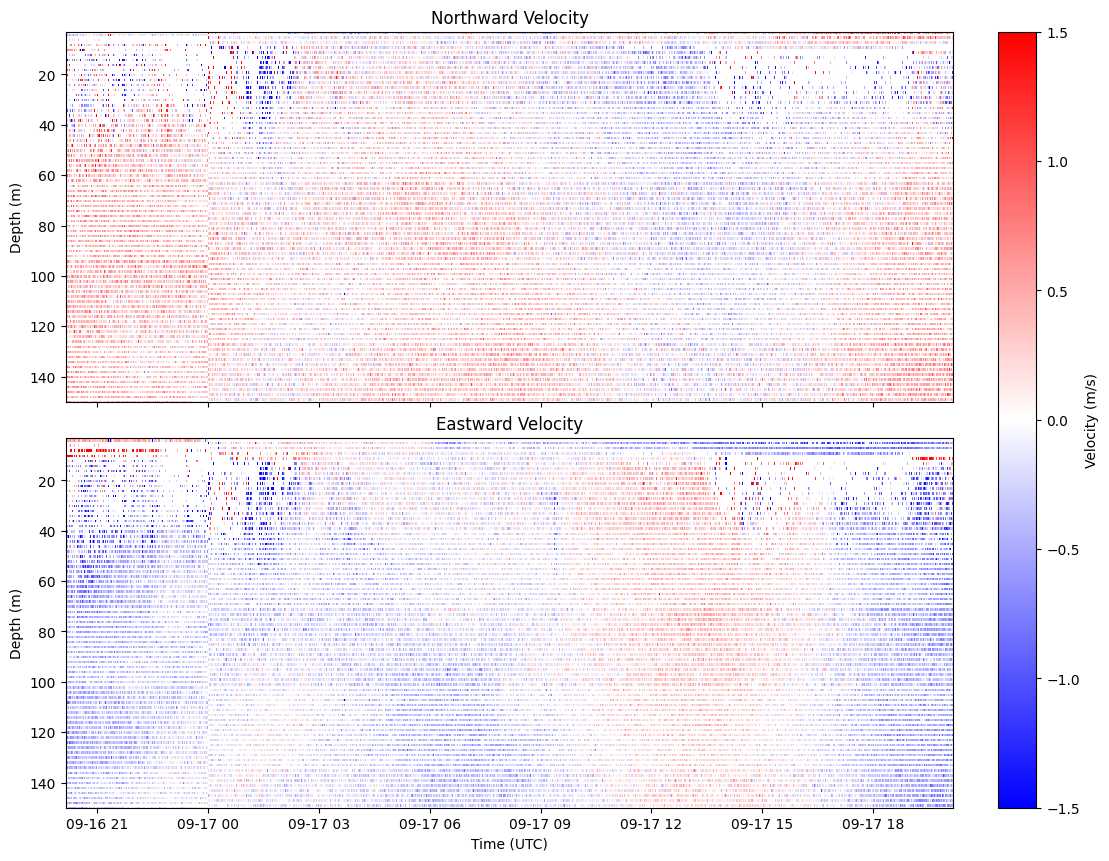

In [12]:
fig, ax = plt.subplots(2,1,figsize = (11,8.5), constrained_layout = True, sharex = True, sharey = True)

pmesh0 = ax[0].pcolormesh(adcp.time, adcp.depth, adcp.v, cmap = 'bwr', vmin = -1.5, vmax = 1.5)
pmesh1 = ax[1].pcolormesh(adcp.time, adcp.depth, adcp.u, cmap = 'bwr', vmin = -1.5, vmax = 1.5)
fig.colorbar(pmesh0, ax = [ax[0],ax[1]], label = 'Velocity (m/s)')

ax[-1].invert_yaxis()
ax[-1].set_ylim(150, 3)

ax[0].set_title('Northward Velocity')
ax[1].set_title('Eastward Velocity')

ax[-1].set_xlabel('Time (UTC)')
ax[0].set_ylabel('Depth (m)')
ax[1].set_ylabel('Depth (m)')

plt.savefig('../figures/sevip_adcp.png', dpi = 300)